In [1]:
import os
import copy
import random
from collections import defaultdict

import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
IMG_H = 256
IMG_W = 256

DATA_DIR = '../data/resampled_png/'

EPOCHS = 10
BATCH_SIZE = 32
NUM_WORKERS = 8

## Convert from .bmp to .png

In [3]:
# def bmp_to_jpg(root_dir, save_path):
#     data_path = os.path.join(root_dir)
#     for class_dir in os.listdir(data_path):
#         to_class_path = os.path.join(data_path, class_dir)
#         os.makedirs(f'{save_path}{class_dir}/')
#         for f_name in os.listdir(to_class_path):
#             f_path = os.path.join(to_class_path, f_name)
#             img = Image.open(f_path)
#             new_img = img.resize((IMG_H, IMG_W))
#             f_new_name = f_name.split('.')
#             new_img.save(f'{save_path}{class_dir}/{f_new_name[0]}.png', 'png')

In [4]:
# bmp_to_jpg('../data/resampled/', DATA_DIR)

## Augmentation and preparation

In [5]:
images_filepaths = []
class_names = {}
counter = 0
random.seed(42)
for class_name in os.listdir(DATA_DIR):
    if class_name not in class_names:
        class_names[class_name] = float(counter)
        counter += 1
    class_dir = os.path.join(DATA_DIR, class_name)
    for f in os.listdir(class_dir):
        images_filepaths.append(os.path.join(class_dir, f))
        random.shuffle(images_filepaths)
len(images_filepaths)

2500

In [6]:
class_names

{'Нормобласты': 0.0,
 'Сегментноядерный нейтрофил': 1.0,
 'Палочкоядерный нейтрофил': 2.0,
 'Миелоцит': 3.0,
 'Бласты': 4.0}

In [7]:
random.seed(42)
random.shuffle(images_filepaths)

test_size = int(len(images_filepaths) * 0.1)
train_size = int((len(images_filepaths) - test_size) * 0.8)

train_images_filepaths = images_filepaths[:train_size]
val_images_filepaths = images_filepaths[train_size:-test_size]
test_images_filepaths = images_filepaths[-test_size:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

1800 450 250


In [8]:
counter = {}
for path in val_images_filepaths:
    p = path.split('/')[3]
    if p not in counter:
        counter[p] = 1
    counter[p] += 1
counter

{'Сегментноядерный нейтрофил': 90,
 'Палочкоядерный нейтрофил': 101,
 'Бласты': 80,
 'Нормобласты': 95,
 'Миелоцит': 89}

In [9]:
ratio = {}
for t in counter:
    ratio[t] = counter[t]/len(images_filepaths)*100
ratio

{'Сегментноядерный нейтрофил': 3.5999999999999996,
 'Палочкоядерный нейтрофил': 4.04,
 'Бласты': 3.2,
 'Нормобласты': 3.8,
 'Миелоцит': 3.56}

In [10]:
ln = len(ratio)
w_c = {}
for i in range(ln):
    if len(ratio) == 0:
        break
    mx = max(ratio, key=ratio.get)
    mn = min(ratio, key=ratio.get)
    if mx not in w_c and mn not in w_c and mx != mn:
        w_c[mn] = ratio[mx]
        w_c[mx] = ratio[mn]
        ratio.pop(mx)
        ratio.pop(mn)
    else:
        w_c[mx] = ratio[mx]
        ratio.pop(mx)
        break
w_c

{'Бласты': 4.04,
 'Палочкоядерный нейтрофил': 3.2,
 'Миелоцит': 3.8,
 'Нормобласты': 3.56,
 'Сегментноядерный нейтрофил': 3.5999999999999996}

In [11]:
weight = torch.tensor(list(w_c.values()))

In [12]:
class Cells(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.float32(image/255)
        
        class_name = image_filepath.split(sep='/')[-2]
        label = class_names[class_name]
        
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [13]:
# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.VerticalFlip(p=0.8),
    A.RandomBrightnessContrast(p=0.8),
    A.RandomGamma(),
    A.Blur(p=0.8),
    A.Flip(),
    ToTensorV2(),
])

In [14]:
train_dataset = Cells(train_images_filepaths, transform)
val_dataset = Cells(val_images_filepaths, transform)

In [15]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()   

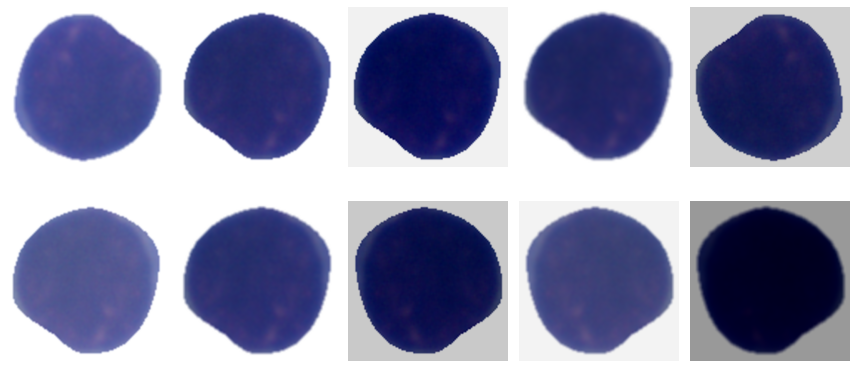

In [16]:
random.seed(42)
visualize_augmentations(train_dataset)

In [17]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [18]:
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True,
)

## Train and validation

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [20]:
# model = models.resnet18(num_classes=len(class_names))
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))
model.to(device)

criterion = nn.CrossEntropyLoss(weight=weight).to(device)
# criterion = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [21]:
def train(train_loader, model, criterion, optimizer, epoch):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    running_corrects = 0
    for i, (images, target) in enumerate(stream, start=1):
        # Prepare batch
        X = images.to(device, non_blocking=True)
        y = target.to(device, non_blocking=True).long()
        y_preds = model(X)
        
        # Check loss
        loss = criterion(y_preds, y)
        
#         # Check accuracy
#         _,y_preds = torch.max(y_preds, dim = 1)
#         running_corrects += torch.sum(y_preds == y.view(1, -1))
#         accuracy = running_corrects.double() / len(train_loader)
        
        # Show metrics
        metric_monitor.update("Loss", loss.item())
#         metric_monitor.update("Accuracy", accuracy)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch+1, metric_monitor=metric_monitor)
        )

In [22]:
def validate(val_loader, model, criterion, epoch):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    running_corrects = 0 
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            X = images.to(device, non_blocking=True)
            y = target.to(device, non_blocking=True).long()
            y_preds = model(X)
            loss = criterion(y_preds, y)
#             _,y_preds = torch.max(y_preds, dim = 1)
#             running_corrects += torch.sum(y_preds == y.view(1, -1))
#             accuracy = running_corrects.double() / len(val_loader)
            metric_monitor.update("Loss", loss.item())
#             metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch+1, metric_monitor=metric_monitor)
            )

In [23]:
for epoch in range(EPOCHS):
    train(train_loader, model, criterion, optimizer, epoch)
    validate(val_loader, model, criterion, epoch)

  0%|          | 0/57 [00:00<?, ?it/s]/home/archie/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Epoch: 10. Validation. Loss: 0.310: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


## Testing

In [24]:
class CellsInference(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.float32(image/255)
        
        class_name = image_filepath.split(sep='/')[-2]
        label = class_names[class_name]

        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

test_transform = A.Compose(
    [
        ToTensorV2(),
    ]
)
test_dataset = CellsInference(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True,
)

In [25]:
# prepare to count predictions for each class
model = model.eval()
swap_class_names = dict([(value, key) for key, value in class_names.items()])
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True).long()
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[swap_class_names[label.item()]] += 1
            total_pred[swap_class_names[label.item()]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / (total_pred[classname])
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class Нормобласты is: 93.2 %
Accuracy for class Сегментноядерный нейтрофил is: 88.1 %
Accuracy for class Палочкоядерный нейтрофил is: 72.5 %
Accuracy for class Миелоцит is: 100.0 %
Accuracy for class Бласты is: 100.0 %


In [26]:
total_accuracy = 0
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / (total_pred[classname])
    total_accuracy += accuracy
print("Total accuracy on all classes is {:.1f} %".format(total_accuracy/ len(swap_class_names)))

Total accuracy on all classes is 90.8 %


## Saving

In [27]:
torch.save(model.state_dict(), 'model')